In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re

#### Hilfsfunktionen

In [3]:
def extract_avg_of_runtime(df):
    """Extrahiert den durchschnittlichen Runtime-Wert aus der Spalte 'Runtime' und ersetzt ihn durch die Minutenanzahl."""
    
    def extract_runtime(runtime):
        """Extrahiert die Minuten oder den Durchschnitt aus der Runtime-Spalte."""
        
        if pd.isna(runtime):
            return np.nan
        
        # Falls der Wert bereits eine Zahl ist (nach dem ersten Aufruf)
        if isinstance(runtime, (int, float)):
            return runtime
        
        # Prüfen, ob die Runtime in Minuten angegeben ist
        if "minutes:" in runtime:
            try:
                minutes = int(runtime.split("minutes:")[1].strip())
                return minutes
            except ValueError:
                return np.nan
        
        # Prüfen, ob der Durchschnitt angegeben ist
        if "avg:" in runtime: 
            try:
                avg = int(runtime.split("avg:")[1].strip())
                return avg
            except ValueError:
                return np.nan

        # Falls der Wert nicht im erwarteten Format ist
        return np.nan
    
    # Anwenden der Funktion auf die Runtime Spalte
    df.loc[:, "Runtime"] = df["Runtime"].apply(extract_runtime)

    return df

In [4]:
#für die Funktion 'cleaning_movies'
def clean_and_convert_runtime_to_minutes(df):
    '''Die Spalte Runtime in netflix_movies.csv wird durch unnoetige Zeichen bereinigt und die Filmzeit in Minuten konvertiert'''

    # Ersetze "." mit einem Leerzeichen
    df["Runtime"] = df["Runtime"].str.replace(r"\.", " ", regex=True)
    
    # Entferne "min" und leere Leerzeichen
    df["Runtime"] = df["Runtime"].str.replace("min", "").str.strip()
    
    def convert_to_minutes(runtime):
        '''Konvertiert Fimzzeiten einheitlich zu Minuten'''
        
        # Wenn die Runtime leer oder unnkown hat
        if pd.isna(runtime) or runtime == "unknown" or runtime == "":
            return np.nan
        
        # Prüfen, ob die Zeit in Stunden und Minuten vorliegt
        if "h" in runtime:
            hours, minutes = runtime.split("h")
            hours = int(hours.strip()) if hours.strip() else 0
            minutes = int(minutes.strip()) if minutes.strip() else 0
            total_minutes = hours * 60 + minutes
        else:
            # Falls nur Minuten vorhanden sind
            total_minutes = int(runtime.strip())
        
        return f"minutes:{total_minutes}"

    # Anwenden der Funktion auf die Runtime Spalte
    df["Runtime"] = df["Runtime"].apply(convert_to_minutes)

    return df

In [5]:
#fuer die Funktionn 'cleaning_series'
def clean_runtime_column(df):
    """Bereinigt die Runtime-Spalte und berechnet Min, Max & Durchschnitt."""

    #entferne unnoetige Zeichenketten
    runtime_col = df["Runtime"].astype(str).str.replace(r"[^\d\-–]", "", regex=True)

    def process_runtime(value):

        #ersetze den "En-Dash" durch einen Bindestrich 
        value = value.replace("–", "-")

        #extrahiere alle Zahlen aus dem String
        numbers = re.findall(r"\d+", value)

        if not numbers:
            return np.nan

        # wandle die Zeichen zu einer Liste von Zahlen um
        numbers = list(map(int, numbers))

        if len(numbers) == 1:
            return f"min:{numbers[0]},max:{numbers[0]},avg:{numbers[0]}"

        if len(numbers) == 2:
            minimum, maximum = numbers
            avg = (minimum + maximum) // 2
            return f"min:{minimum},max:{maximum},avg:{avg}"

        return np.nan

    df["Runtime"] = runtime_col.apply(process_runtime)
    return df

In [6]:
#fuer die Funktion "cleaning_series" und "cleaning_movies"
def extract_year(premiere_value):

    # Falls NaN oder kein String, leere Rückgabe
    if not isinstance(premiere_value, str):
        return ""
        
    # Iteriere über die Jahre 2015-20
    for year in range(2015, 2026):
        if str(year) in premiere_value:
            return str(year)
    
    return ""  # Falls kein Jahr gefunden wurde

### 1. Aufgabe: Webscrapen der Daten aus den Wikipedia-Seiten:
### Netflix Originals Serien:
[Netflix-Originals-Series](https://en.wikipedia.org/wiki/List_of_Netflix_original_programming)

### Netflix Originals Filme:
[Netflix-Originals-Movies-LIST](https://en.wikipedia.org/wiki/Lists_of_Netflix_original_films)

[2015-2017](https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2015%E2%80%932017))
[2018](https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2018))
[2019](https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2019))
[2020](https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2020))
[2021](https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2021))
[2022](https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2022))
[2023](https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2023))
[2024](https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2024))

In [8]:
def scraping_netflix_originals():
    series_url = "https://en.wikipedia.org/wiki/List_of_Netflix_original_programming"
    movie_urls = [
        "https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2015%E2%80%932017)",
        "https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2018)",
        "https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2019)",
        "https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2020)",
        "https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2021)",
        "https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2022)",
        "https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2023)",
        "https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2024)#Shorts",
    ]
    
    # Netflix Serien scrapen
    try:
        df_series_list = pd.read_html(series_url)
        df_of_series = pd.concat(df_series_list, ignore_index=True)
        df_of_series.to_csv("netflix_series.csv", index=False)
    except Exception as e:
        print(f"Fehler beim Scrapen der Serien: {e}")

    # Netflix Filme scrapen
    movie_list = []
    for url in movie_urls:
        try:
            df_movies_list = pd.read_html(url)
            movie_list.append(pd.concat(df_movies_list, ignore_index=True))
        except Exception as e:
            print(f"Fehler beim Scrapen der Filme von {url}: {e}")

    if movie_list:
        df_of_movies = pd.concat(movie_list, ignore_index=True)
        df_of_movies.to_csv("netflix_movies.csv", index=False)
    else:
        print("Keine Filme gefunden!")

scraping_netflix_originals()

### 2.Aufgabe: Bereinigen der Daten

In [10]:
def cleaning_series():
    # Daten laden
    df = pd.read_csv("netflix_series.csv")

    # Duplikate entfernen
    df.drop_duplicates(inplace=True)

    # Falls "Genre" leer ist, mit "Subject" befüllen
    df["Genre"] = df["Genre"].fillna(df["Subject"])

    # Nur relevante Spalten behalten
    df = df.loc[:, ["Title", "Genre", "Runtime", "Premiere", "Status", "Subject"]]

    # Zeilen entfernen, die Awaiting release beinhalten
    df = df[df["Title"] != "Awaiting release"]

    # Formatierung von "Genre" und "Runtime"
    df["Genre"] = df["Genre"].astype(str).str.replace("/", ",", regex=False)
    df["Runtime"] = df["Runtime"].astype(str).str.replace("min", "", regex=False)

    # Laufzeitspalte bereinigen
    df = clean_runtime_column(df)

    # Entferne Zeilen mit zu vielen fehlenden Werten
    #df = df.dropna(thresh=5)

    # Entferne Referenznummern ([1], [2], etc.) aus allen Spalten
    df.replace(r"\[\d+\]", "", regex=True, inplace=True)

    # Premiere-Daten in Jahreswerte umwandeln
    df["Premiere"] = df["Premiere"].apply(extract_year)

    # Fehlende Werte mit "Unknown" füllen und entfernen, und die Zeilen entfernen, die in Spalte Status enthalten sind 
    df.fillna("Unknown", inplace=True)
    df = df[df["Status"] != "Unknown"]

    # Bereinigte Daten speichern
    df.to_csv("netflix_series_clean.csv", index=False)

cleaning_series()

In [11]:
def cleaning_movies():
    df = pd.read_csv("netflix_movies.csv")

    # Duplikate entfernen
    df = df.drop_duplicates()

    # benenne Spalten um für die Einheitlichkeit
    df.rename(columns={"Release date": "Premiere"}, inplace=True)

    # Nur relevante Spalten behalten
    df = df.loc[:, ["Title", "Premiere", "Genre", "Runtime", "Language"]]

    # Entferne Zeilen, die komplett leer sind
    df.dropna(how="all", inplace=True)

    # Falls "Genre" leer ist, mit "Documentary" auffüllen
    df["Genre"] = df["Genre"].fillna("Documentary")

    # Bereinige das Genre-Format
    df["Genre"] = df["Genre"].str.replace(r"[\\/]", "", regex=True)
    df["Genre"] = df["Genre"].str.replace("-", " ", regex=True)

    # Laufzeit in Minuten umwandeln
    df = clean_and_convert_runtime_to_minutes(df)

    # Premiere-Datum bereinigen
    df["Premiere"] = df["Premiere"].apply(extract_year)

    # Speichere die bereinigte Datei
    df.to_csv("netflix_movies_clean.csv", index=False)

cleaning_movies()

### 3. Aufgabe: Einsichten

In [13]:
# Laden der bereinigten CSV-Dateien
series = pd.read_csv("netflix_series_clean.csv")
movies = pd.read_csv("netflix_movies_clean.csv")

# Hinzufügen der Kategorie-Spalte
series["category"] = "Series"
movies["category"] = "Movies"

# Zusammenführen der beiden DataFrames
df = pd.concat([series, movies], ignore_index=True)

### 3.1 Einsicht: In welchen Genres wurden die meisten Filme und Serien produziert?

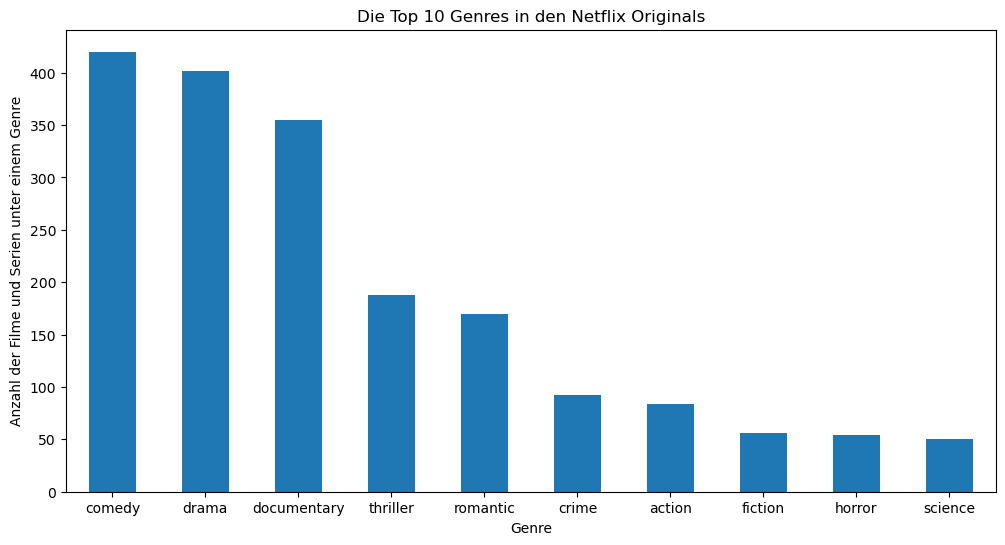

In [15]:
# Funktion zum Zählen und Plotten der häufigsten Genres
def plot_top_ten_genres(df):

    # die Genres, die wir zählen wollen in eine Liste
    valid_genres = df["Genre"].str.replace(",", " ").str.split(r'\s+', expand=True).stack().str.strip().str.lower()

    # Häufigkeit der Genres zählen
    count_genres = valid_genres.value_counts().head(10)

    # Diagramm erstellen
    plt.figure(figsize=(12,6))
    plt.title("Die Top 10 Genres in den Netflix Originals")
    plt.xlabel("Genre")
    plt.ylabel("Anzahl der Filme und Serien unter einem Genre")
    count_genres.plot(kind="bar")
    plt.xticks(rotation=0)
    plt.show()
    
plot_top_ten_genres(df)

Man erkennt, dass unter der Anzahl der produzierten Originals, das Genre Comedy knapp das Genre Drama schlägt. Überraschenderweise ist das Genre Documentary auf Platz 3. 

### 3.2 Einsicht: Wie viele Originals wurden pro Jahr veröffentlicht?

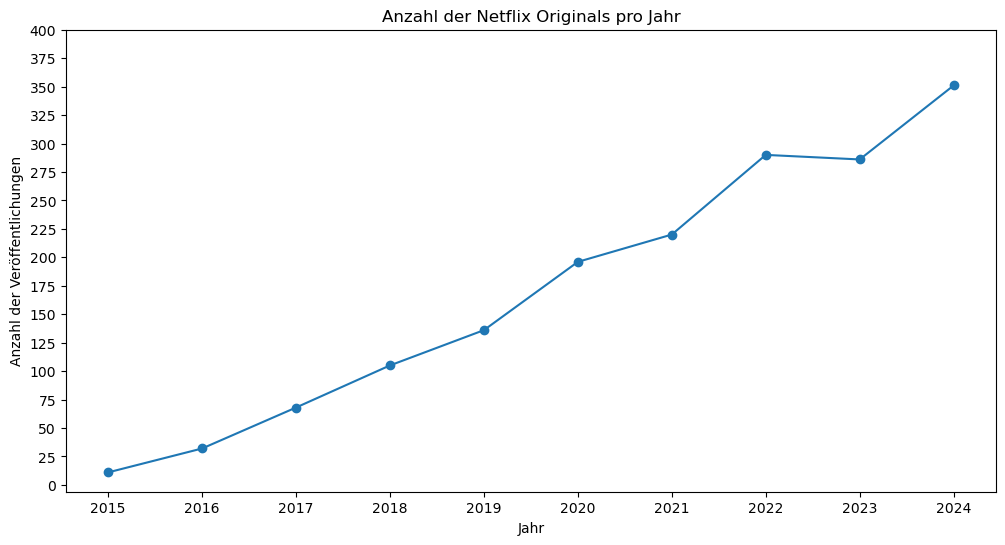

In [18]:
def plot_yearly_releases(df):
    
    # Filtere Filme, deren Premiere 2025 ist
    df = df[df['Premiere'] != 2025]
    
    # Zähle die Veröffentlichungen pro Jahr
    count_premiere = df["Premiere"].value_counts().sort_index()
    
    # Diagramm erstellen
    plt.figure(figsize=(12,6))
    count_premiere.plot(kind="line", marker="o")
    plt.title("Anzahl der Netflix Originals pro Jahr")
    plt.xlabel("Jahr")
    plt.ylabel("Anzahl der Veröffentlichungen")
    plt.xticks(ticks=np.arange(2015, 2025, step=1))
    plt.yticks(ticks=np.arange(0, 401, step=25))
    plt.xticks(rotation=0)
    plt.show()

plot_yearly_releases(df)

Die Originals 2025 habe ich zu Anfang des Projektes rausgelassen, da bis zu dem Tag zu wenige Originals veröffentlicht wurden. Das Diagramm zeigt, dass Netflix sich bemüht weltweit Serien und Filme zu produzieren. Auch in der Zeit von Corona ist die Anzahl stark gestiegen.

### 3.3 Einsicht: Wie ist die durchschnittliche Laufzeit pro Original? 

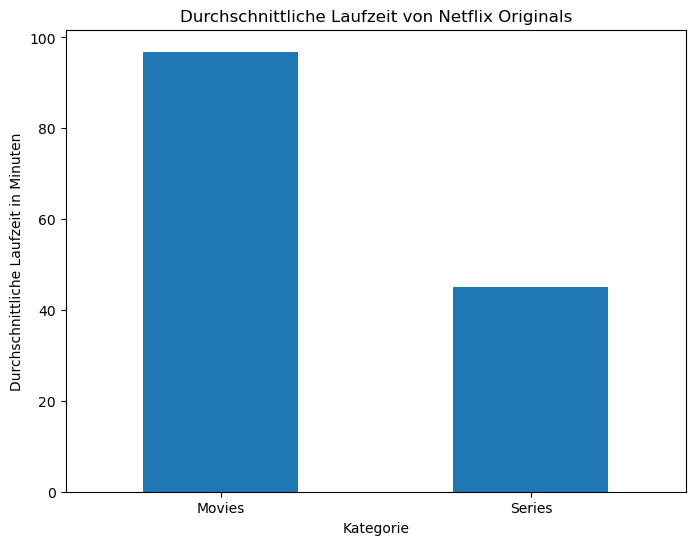

In [21]:
def avg_runtime(df):
    
    # Entferne 2025 als Premiere
    df = df[df["Premiere"] != 2025]

    # Funktion zum Extrahieren des Durchschnitts an
    df = extract_avg_of_runtime(df)

    # Berechnung des Durchschnitts der Laufzeit pro Kategorie
    avg_runtime_per_cat = df.groupby("category")["Runtime"].mean() 

    # Diagramm erstellen
    plt.figure(figsize=(8, 6))
    avg_runtime_per_cat.plot(kind="bar")
    plt.title("Durchschnittliche Laufzeit von Netflix Originals")
    plt.xlabel("Kategorie")
    plt.ylabel("Durchschnittliche Laufzeit in Minuten")
    plt.xticks(rotation=0)
    plt.show()

avg_runtime(df)

Die durchschnittliche Laufzeit der Filme beträgt 95 Minuten, während die der Serien ungefähr 45 Minuten

### 3.4 Einsicht: Wie viele Serien wurden Renewed für 2025?

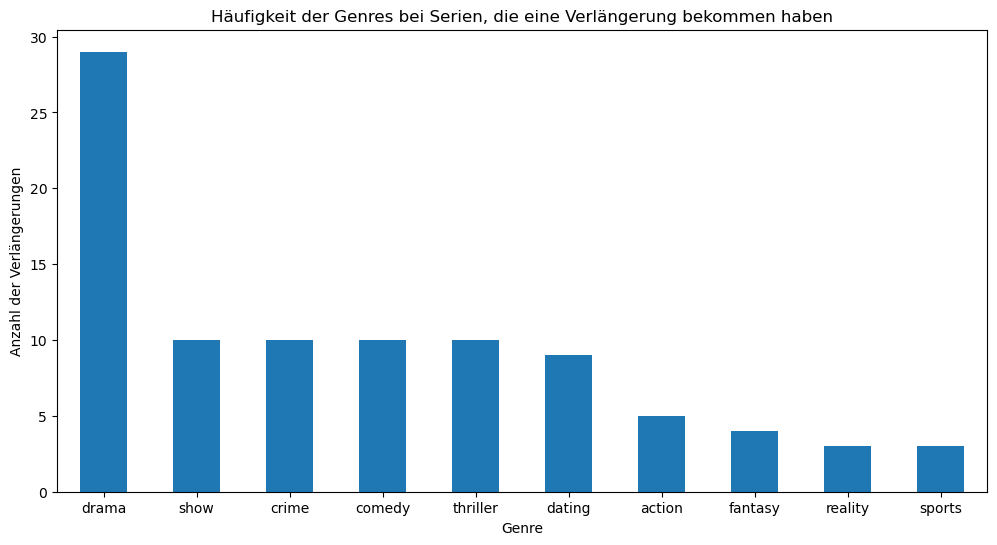

In [24]:
def renewed_series():
    
    # Filtern nach Serien, die verlängert wurden
    renewed_series = series[series['Status'].str.contains("Renewed", case=False, na=False)]

    # Aufteilen der Genres in eine Liste für jedes Genre
    all_genres = renewed_series["Genre"].str.replace(",", " ").str.split(r'\s+', expand=True).stack().str.strip().str.lower()

    # Häufigkeit der Genres zählen
    genre_counts = all_genres.value_counts().head(10)

    # Diagramm erstellen
    plt.figure(figsize=(12, 6))
    plt.title("Häufigkeit der Genres bei Serien, die eine Verlängerung bekommen haben")
    plt.xlabel("Genre")
    plt.ylabel("Anzahl der Verlängerungen")
    genre_counts.plot(kind="bar")
    plt.xticks(rotation=0)
    plt.show()

renewed_series()

Für das Jahr 2025 wurden vor allem Drama, von der Anzahl aus, um weitere Folgen verlängert. Man erkennt jedoch, dass
die Verlängerungen der Serien in sehr vielen Genres gleichmäßig zu finden sind, was zeigt, dass Netflix sich bemüht alle Fans jeglichen Genres  mit neuen Inhalten zufrieden zu stellen, und eventuell so ihr Abo bei zu behalten, wenn angekündgt wird: "Es folgt eine weitere Staffel  2025."